In [ ]:
pip install meteostat

# Data Preprocessing and Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


## Getting consumption Dataframe


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/ML Collab/household_power_consumption.csv"
dtypes = {
  'Date': str,
  'Time': str,
  'Global_active_power': float,
  'Global_reactive_power': float,
  'Voltage': float,
  'Global_intensity': float,
  'Sub_metering_1': float,
  'Sub_metering_2': float,
  'Sub_metering_3': float
}
try:
  df_cons = pd.read_csv(file_path, sep=';', dtype=dtypes, na_values=['nan','?'])
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
  df_cons = None

df_cons['Datetime'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop original date and time columns to clean up the dataset
df_cons.drop(columns=['Date', 'Time'], inplace=True)
df_cons.info()
df_cons.head()
df_cons.dropna(inplace=True)
df_cons.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly, Point

# Set time period
start = datetime(2006,12,16, 17,27,00)
end = datetime(2010, 12, 31, 23, 59)
sceaux= Point(48.7943, 2.2715)
# Get hourly data
df_weather = Hourly(sceaux, start, end)
df_weather = df_weather.fetch()
df_weather['time'] = df_weather.index
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35430 entries, 2006-12-16 18:00:00 to 2010-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   temp    35316 non-null  float64       
 1   dwpt    35316 non-null  float64       
 2   rhum    35316 non-null  float64       
 3   prcp    23127 non-null  float64       
 4   snow    0 non-null      float64       
 5   wdir    35278 non-null  float64       
 6   wspd    35317 non-null  float64       
 7   wpgt    0 non-null      float64       
 8   pres    35059 non-null  float64       
 9   tsun    0 non-null      float64       
 10  coco    0 non-null      float64       
 11  time    35430 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 3.5 MB


In [ ]:
df_weather['Year'] = df_weather['time'].dt.year
df_weather['Month'] = df_weather['time'].dt.month
df_weather['Day'] = df_weather['time'].dt.day
df_weather['Hour'] = df_weather['time'].dt.hour
df_cons['Minute'] = df_cons['Datetime'].dt.minute
df_weather['Day_of_week'] = df_weather['time'].dt.dayofweek #0 being monday and 6 being sunday
df_weather.drop(columns=['time'], inplace=True)
df_weather.isnull().sum()
df_weather.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Year,Month,Day,Hour,Day_of_week
time,,,,,,,,,,,,,,,,
2006-12-16 18:00:00,6.9,4.2,83.0,NaN,NaN,340.0,14.8,NaN,1026.8,NaN,NaN,2006,12,16,18,5
2006-12-16 19:00:00,6.4,3.7,83.0,0.0,NaN,340.0,14.8,NaN,1027.5,NaN,NaN,2006,12,16,19,5
2006-12-16 20:00:00,6.0,4.0,87.0,0.0,NaN,310.0,7.6,NaN,1028.0,NaN,NaN,2006,12,16,20,5
2006-12-16 21:00:00,5.6,3.8,88.0,NaN,NaN,310.0,7.6,NaN,1028.6,NaN,NaN,2006,12,16,21,5
2006-12-16 22:00:00,5.1,3.8,91.0,0.0,NaN,260.0,7.6,NaN,1028.9,NaN,NaN,2006,12,16,22,5


In [ ]:
# Merge datasets based on the datetime
df_both = pd.merge(df_cons, df_weather, left_on='Datetime', right_on='time', how='outer')
df_both.info()
df_both.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050558 entries, 0 to 2050557
Data columns (total 25 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
 8   Minute                 float64       
 9   temp                   float64       
 10  dwpt                   float64       
 11  rhum                   float64       
 12  prcp                   float64       
 13  snow                   float64       
 14  wdir                   float64       
 15  wspd                   float64       
 16  wpgt                   float64       
 17  pres                   float64       
 18  tsun                  

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,Minute,temp,...,wspd,wpgt,pres,tsun,coco,Year,Month,Day,Hour,Day_of_week
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,24.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,27.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_both.dropna(subset=['Global_active_power'], inplace=True)
df_both.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0
Minute,0
temp,2015242


In [ ]:
df_both.fillna(method='ffill', inplace=True)
df_both.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0
Minute,0
temp,36


In [ ]:
df_both.drop(columns=['tsun','coco', 'wpgt', 'snow', ], inplace=True)
df_both.dropna(inplace=True)
df_both.isna().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0
Minute,0
temp,0


In [ ]:
df_both.drop(columns=['Global_reactive_power','Global_intensity', 'Voltage', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3'], inplace=True)
df_both.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049184 entries, 96 to 2049715
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Global_active_power  float64       
 1   Datetime             datetime64[ns]
 2   Minute               float64       
 3   temp                 float64       
 4   dwpt                 float64       
 5   rhum                 float64       
 6   prcp                 float64       
 7   wdir                 float64       
 8   wspd                 float64       
 9   pres                 float64       
 10  Year                 float64       
 11  Month                float64       
 12  Day                  float64       
 13  Hour                 float64       
 14  Day_of_week          float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 250.1 MB


In [ ]:
from scipy.stats import zscore

numerical_cols = df_both.select_dtypes(include=np.number).columns
# Calculate z-scores for all columns
z_scores = np.abs(zscore(df_both[numerical_cols]))

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Identify outliers
outliers = np.where(z_scores > threshold)

# Remove rows with outliers
df_both = df_both[(z_scores < 3).all(axis=1)]

df_both.describe()

,Global_active_power,Datetime,Minute,temp,dwpt,rhum,prcp,wdir,wspd,pres,Year,Month,Day,Hour,Day_of_week
count,1.959701e+06,1959701,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06,1.959701e+06
mean,1.014761e+00,2008-12-03 07:18:11.523992832,2.949136e+01,1.244506e+01,6.925784e+00,7.143586e+01,3.389017e-02,1.920901e+02,1.089246e+01,1.016688e+03,2.008426e+03,6.480904e+00,1.574219e+01,1.141204e+01,2.984727e+00
min,7.600000e-02,2006-12-16 19:00:00,0.000000e+00,-6.400000e+00,-9.900000e+00,2.300000e+01,0.000000e+00,1.000000e+01,0.000000e+00,9.875000e+02,2.006000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.060000e-01,2007-12-11 22:35:00,1.400000e+01,7.500000e+00,3.100000e+00,6.000000e+01,0.000000e+00,1.100000e+02,7.600000e+00,1.011300e+03,2.007000e+03,4.000000e+00,8.000000e+00,5.000000e+00,1.000000e+00
50%,5.660000e-01,2008-12-01 01:32:00,2.900000e+01,1.250000e+01,7.400000e+00,7.400000e+01,0.000000e+00,2.000000e+02,1.120000e+01,1.017000e+03,2.008000e+03,6.000000e+00,1.600000e+01,1.100000e+01,3.000000e+00
75%,1.496000e+00,2009-11-21 20:46:00,4.400000e+01,1.740000e+01,1.110000e+01,8.400000e+01,0.000000e+00,2.700000e+02,1.480000e+01,1.022600e+03,2.009000e+03,9.000000e+00,2.300000e+01,1.700000e+01,5.000000e+00
max,4.262000e+00,2010-11-26 21:02:00,5.900000e+01,3.300000e+01,2.230000e+01,1.000000e+02,1.000000e+00,3.600000e+02,2.590000e+01,1.043500e+03,2.010000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00
std,9.017448e-01,NaN,1.731504e+01,6.895359e+00,5.527027e+00,1.611008e+01,1.398782e-01,1.035977e+02,5.107378e+00,9.239259e+00,1.121719e+00,3.394234e+00,8.811746e+00,6.932119e+00,1.992717e+00


In [ ]:
df_both.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1959701 entries, 96 to 2049715
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Global_active_power  float64       
 1   Datetime             datetime64[ns]
 2   Minute               float64       
 3   temp                 float64       
 4   dwpt                 float64       
 5   rhum                 float64       
 6   prcp                 float64       
 7   wdir                 float64       
 8   wspd                 float64       
 9   pres                 float64       
 10  Year                 float64       
 11  Month                float64       
 12  Day                  float64       
 13  Hour                 float64       
 14  Day_of_week          float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 239.2 MB


In [ ]:
df_both = df_both.set_index('Datetime')

# Convert index to DatetimeIndex
df_both.index = pd.to_datetime(df_both.index)

df_resampled = df_both.resample('60min').mean()

df_resampled = df_resampled.drop(columns=['Minute'])
df_resampled = df_resampled.drop(columns=['Year'])

# df_resampled = df_resampled.dropna()



# df_both['energy_Wh'] = df_both['Global_active_power'] * (1000 / 60)
# df_resampled['Global_active_power'] = (df_resampled['energy_Wh'] * (60 / 1000)) / 15

# df['energy_Wh'] = df['power_kW'] * (1000 / 60)  # Convert power to energy per minute
# df_resampled = df.resample('15T').agg({
#     'energy_Wh': 'sum',        # Sum energy over 15 minutes
#     'day_of_week': 'first',    # Keep the first day's value
#     'temperature': 'mean',     # Example: average temperature over 15 minutes
#     'voltage': 'mean',         # Example: average voltage
# })

df_both = df_resampled
# df_both.drop(columns=['energy_Wh'], inplace=True)

In [ ]:
df_both.isna().sum()

,0
Global_active_power,1337
temp,1337
dwpt,1337
rhum,1337
prcp,1337
wdir,1337
wspd,1337
pres,1337
Month,1337
Day,1337


In [ ]:
df_both['previous1hr'] = df_both['Global_active_power'].shift(1)
df_both['previous2hr'] = df_both['Global_active_power'].shift(2)
df_both['previous3hr'] = df_both['Global_active_power'].shift(3)
# df_both.dropna(inplace=True)
df_both.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34587 entries, 2006-12-16 19:00:00 to 2010-11-26 21:00:00
Freq: 60min
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  33250 non-null  float64
 1   temp                 33250 non-null  float64
 2   dwpt                 33250 non-null  float64
 3   rhum                 33250 non-null  float64
 4   prcp                 33250 non-null  float64
 5   wdir                 33250 non-null  float64
 6   wspd                 33250 non-null  float64
 7   pres                 33250 non-null  float64
 8   Month                33250 non-null  float64
 9   Day                  33250 non-null  float64
 10  Hour                 33250 non-null  float64
 11  Day_of_week          33250 non-null  float64
 12  previous1hr          33249 non-null  float64
 13  previous2hr          33248 non-null  float64
 14  previous3hr          33246 non-null  fl

In [ ]:
df_both.head()

,Global_active_power,temp,dwpt,rhum,prcp,wdir,wspd,pres,Month,Day,Hour,Day_of_week,previous1hr,previous2hr,previous3hr
Datetime,,,,,,,,,,,,,,,
2006-12-16 19:00:00,3.400233,6.4,3.7,83.0,0.0,340.0,14.8,1027.5,12.0,16.0,19.0,5.0,NaN,NaN,NaN
2006-12-16 20:00:00,3.268567,6.0,4.0,87.0,0.0,310.0,7.6,1028.0,12.0,16.0,20.0,5.0,3.400233,NaN,NaN
2006-12-16 21:00:00,3.056467,5.6,3.8,88.0,0.0,310.0,7.6,1028.6,12.0,16.0,21.0,5.0,3.268567,3.400233,NaN
2006-12-16 22:00:00,2.200133,5.1,3.8,91.0,0.0,260.0,7.6,1028.9,12.0,16.0,22.0,5.0,3.056467,3.268567,NaN
2006-12-16 23:00:00,2.061600,4.4,3.2,92.0,0.0,250.0,3.6,1029.4,12.0,16.0,23.0,5.0,2.200133,3.056467,3.400233


In [ ]:
needs_scaling = [ 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd',
       'pres', 'previous1hr', 'previous2hr',
       'previous3hr']
scaler = MinMaxScaler()
df_both[needs_scaling] = scaler.fit_transform(df_both[needs_scaling])
df_both.head()

,Global_active_power,temp,dwpt,rhum,prcp,wdir,wspd,pres,Month,Day,Hour,Day_of_week,previous1hr,previous2hr,previous3hr
Datetime,,,,,,,,,,,,,,,
2006-12-16 19:00:00,3.400233,0.324873,0.422360,0.779221,0.0,0.942857,0.571429,0.714286,12.0,16.0,19.0,5.0,NaN,NaN,NaN
2006-12-16 20:00:00,3.268567,0.314721,0.431677,0.831169,0.0,0.857143,0.293436,0.723214,12.0,16.0,20.0,5.0,0.821111,NaN,NaN
2006-12-16 21:00:00,3.056467,0.304569,0.425466,0.844156,0.0,0.857143,0.293436,0.733929,12.0,16.0,21.0,5.0,0.788112,0.821111,NaN
2006-12-16 22:00:00,2.200133,0.291878,0.425466,0.883117,0.0,0.714286,0.293436,0.739286,12.0,16.0,22.0,5.0,0.734954,0.788112,NaN
2006-12-16 23:00:00,2.061600,0.274112,0.406832,0.896104,0.0,0.685714,0.138996,0.748214,12.0,16.0,23.0,5.0,0.520334,0.734954,0.821111


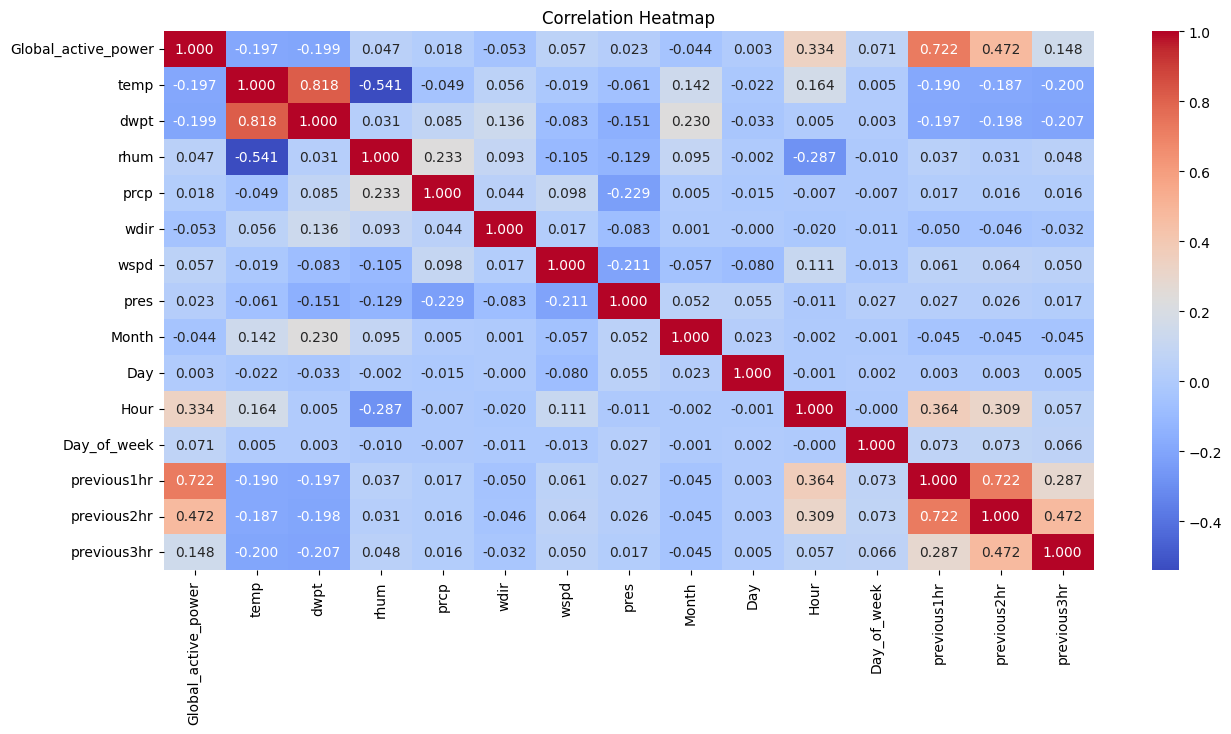

In [ ]:
corr_mat=df_both.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr_mat, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
###########################################
# Saving the scaler and processed dataset #
###########################################

import os
import joblib

drive_save_dir = '/content/drive/MyDrive/ML Collab/'

os.makedirs(drive_save_dir, exist_ok=True)

# Save the scaler
scaler_path = os.path.join(drive_save_dir, 'short_term_scaler.pkl')
joblib.dump(scaler, scaler_path)

# Save the DataFrame
df_both_path = os.path.join(drive_save_dir, 'short_term_consumption.csv')
df_both.to_csv(df_both_path)

print(f"Scaler saved to: {scaler_path}")
print(f"DataFrame saved to: {df_both_path}")



Scaler saved to: /content/drive/MyDrive/ML Collab/short_term_scaler.pkl
DataFrame saved to: /content/drive/MyDrive/ML Collab/short_term_consumption.csv
